In [1]:
#Import Necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.mlab as mlab

In [2]:
#Clean and Arrange Data

data17 = pd.read_excel('anuales_gen_int_2017.xlsx', header=2)
data17['Month'] = pd.DatetimeIndex(data17['Fecha']).month
data17['Day'] = pd.DatetimeIndex(data17['Fecha']).day
data17['Hour'] = pd.DatetimeIndex(data17['Fecha']).hour
data17.index = data17['Fecha']
data17.drop(['Fecha'],axis=1 ,inplace=True)
data17.head()

data17[data17['Demand'] <600] = np.nan
data17.fillna(method='ffill', inplace=True)

Test Statistic                -9.965264e+00
p-value                        2.316053e-17
#Lags Used                     3.300000e+01
Number of Observations Used    8.726000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


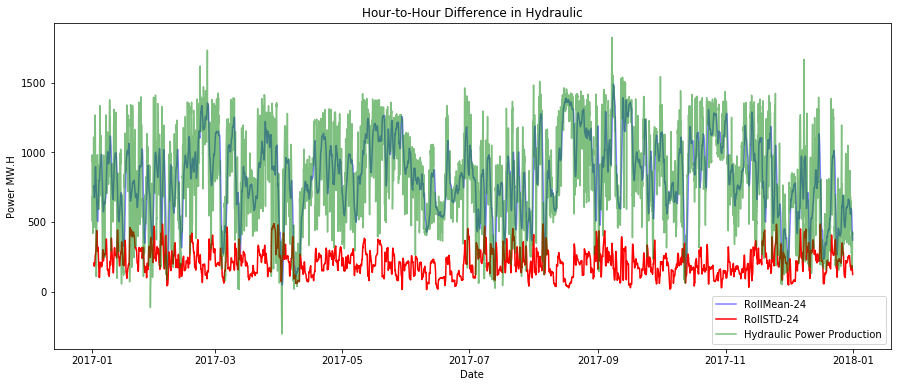

In [3]:
#Stationarity Analysis function
#Stationarity is when the data does not evolve over time. We can clearly see that it does. 
#It is easier to predict Stationary functions, so for unstationary functions, we can try to create a directly related
#function that appears stationary, and after the analysis and prediction we return the structure we removed. 
#For our case, taking the change in hourly demand/supply provides a semi-stationary function. 

def stationarityAnalysis (win, col):
    plt.figure()
    plt.plot(pd.rolling_mean(data17['{}'.format(col)], win), color='blue',alpha=0.5,label='RollMean-{}'.format(win))
    plt.plot(pd.rolling_std(data17['{}'.format(col)],win), color='red', label='RollSTD-{}'.format(win))
    plt.plot(data17['{}'.format(col)], color='green',alpha=0.5,label='{} Power Production'.format(col))
    #diff = data17['{}'.format(energy_src)]-data17['{}'.format(energy_src)].shift()
    #plt.plot(diff, color='gray', alpha = 0.5, label='Differenced Trend')
    plt.ylabel('Power MW.H')
    plt.xlabel('Date')
    plt.title('Hour-to-Hour Difference in {}'.format(col))
    plt.legend(loc='best')
    
    dftest = adfuller(data17['{}'.format(col)], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                            '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print dfoutput
    
    return 

stationarityAnalysis(24, 'Hydraulic')

Test Statistic                -1.049987e+01
p-value                        1.091041e-18
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Test Statistic                  -21.191716
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    8722.000000
Critical Value (5%)              -2.861871
Critical Value (1%)              -3.431100
Critical Value (10%)             -2.566946
dtype: float64


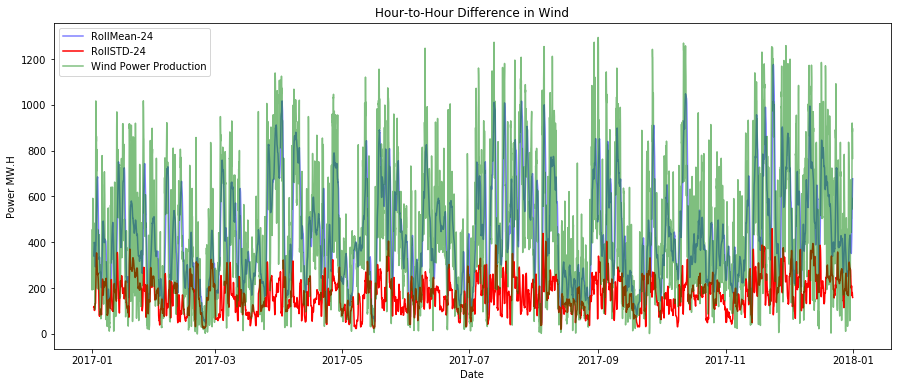

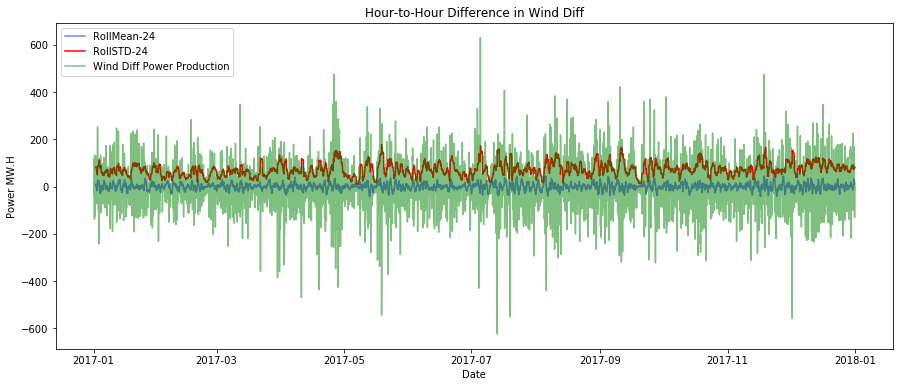

In [4]:
energy_src = 'Wind'
stationarityAnalysis(24, energy_src)

data17['{} Diff'.format(energy_src)] = data17['{}'.format(energy_src)]-data17['{}'.format(energy_src)].shift()
data17['{} Diff'.format(energy_src)].dropna(inplace=True)
stationarityAnalysis(24, '{} Diff'.format(energy_src))

Test Statistic                -6.971658e+00
p-value                        8.633629e-10
#Lags Used                     3.600000e+01
Number of Observations Used    8.723000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Test Statistic                  -20.275724
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8721.000000
Critical Value (5%)              -2.861871
Critical Value (1%)              -3.431100
Critical Value (10%)             -2.566946
dtype: float64


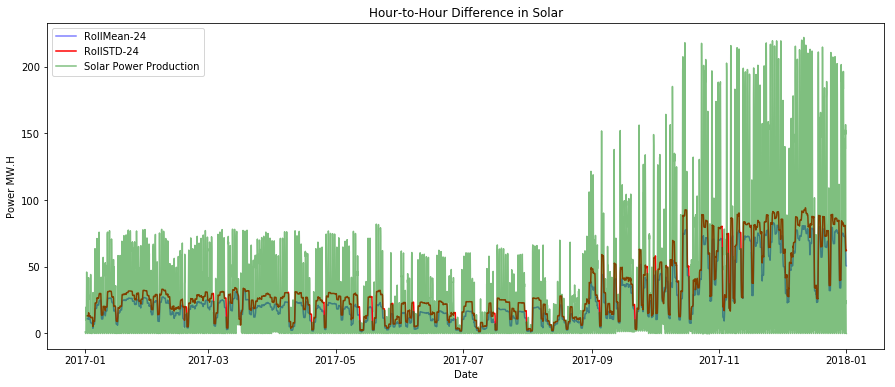

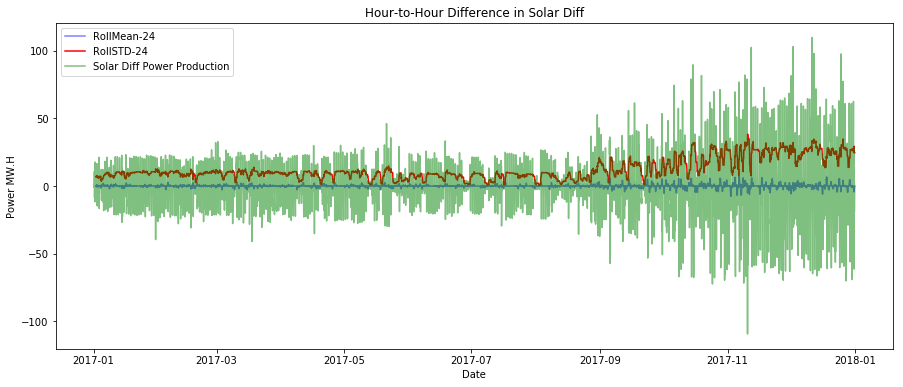

In [5]:
energy_src = 'Solar'
stationarityAnalysis(24, energy_src)

data17['{} Diff'.format(energy_src)] = data17['{}'.format(energy_src)]-data17['{}'.format(energy_src)].shift()
data17['{} Diff'.format(energy_src)].dropna(inplace=True)
stationarityAnalysis(24, '{} Diff'.format(energy_src))

Test Statistic                -8.832209e+00
p-value                        1.757393e-14
#Lags Used                     3.500000e+01
Number of Observations Used    8.724000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Test Statistic                -1.862967e+01
p-value                        2.058068e-30
#Lags Used                     3.700000e+01
Number of Observations Used    8.721000e+03
Critical Value (5%)           -2.861871e+00
Critical Value (1%)           -3.431100e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


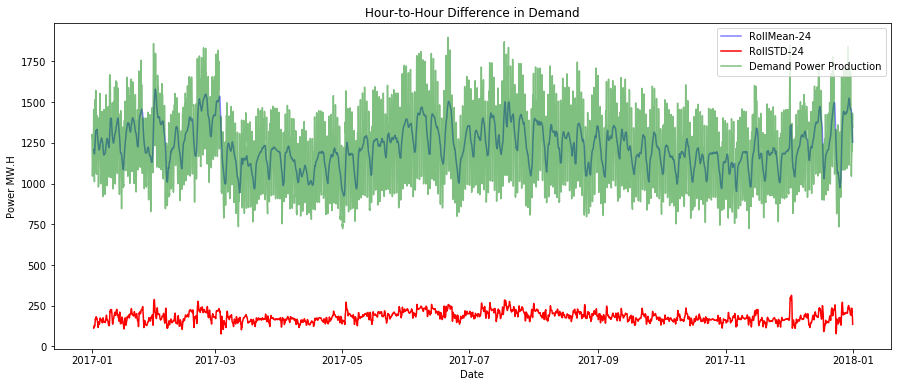

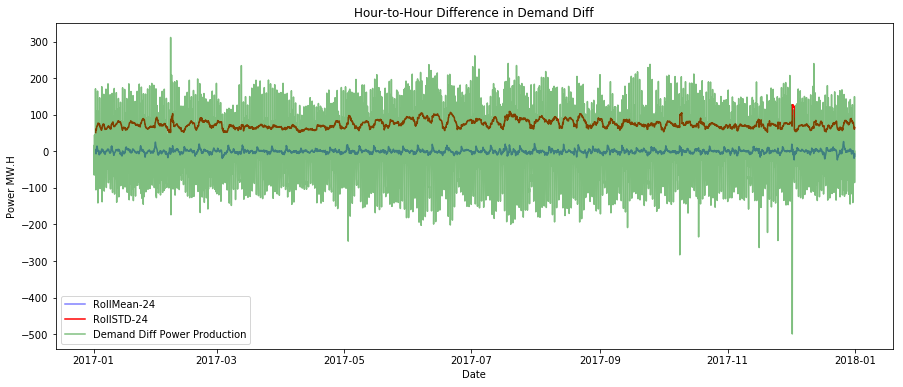

In [6]:
energy_src = 'Demand'
stationarityAnalysis(24, energy_src)

data17['{} Diff'.format(energy_src)] = data17['{}'.format(energy_src)]-data17['{}'.format(energy_src)].shift()
data17['{} Diff'.format(energy_src)].dropna(inplace=True)
stationarityAnalysis(24, '{} Diff'.format(energy_src))

In [7]:
#Main ARIMA (Auto-Regressive Integrated Moving Average) function
#This function takes a window of data and applies ARIMA on it. Meaning, it predicts a smaller window based on original 
#data. After the prediction, it reads the window it predicted and confirms the measurement and integrates it into the 
#window that is used to predict the next period. And so on, and so forth. 

#Function includes plotting functionality of different models and inputs

def ARIMA_analysis(inp, win):

    lag_acf = acf(data17['{}'.format(inp)], nlags = win)
    lag_pacf = pacf(data17['{}'.format(inp)], nlags = win, method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.ylabel('Autocorrelation')
    plt.xlabel('Hour difference')
    #plt.axhline(y=-1.96/np.sqrt(len(data17['Demand Diff'])),linestyle='--',color='gray')
    #plt.axhline(y=1.96/np.sqrt(len(data17['Demand Diff'])),linestyle='--',color='gray')
    plt.title('Autocorrelation Function of Hourly difference in {}'.format(inp))

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function of Hourly difference in {}'.format(inp))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Hour difference')
    plt.tight_layout()
    
    plt.figure()
    model = ARIMA(data17['{}'.format(inp)], order= (2,1,0))
    results_AR = model.fit(disp=-1)
    aa = data17['{} Diff'.format(inp)]
    bb = results_AR.fittedvalues
    #plt.plot(data17['Demand Diff'], alpha=.5)
    #plt.plot(results_AR.fittedvalues, color='red', alpha=.5)
    plt.plot(aa[:24*7], alpha=.5)
    plt.plot(bb[:24*7], color='red', alpha=.5)
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data17['{} Diff'.format(inp)])**2))
    
    plt.figure()
    model2 = ARIMA(data17['{}'.format(inp)], order=(0,1,2))
    results_MA = model.fit(disp=-1)
    aa2 = data17['{} Diff'.format(inp)]
    bb2 = results_MA.fittedvalues
    plt.plot(aa2[:24*7], alpha=0.5)
    plt.plot(bb2[:24*7], color='red', alpha=.5)
    #plt.plot(data17['Demand Diff'], alpha=.5)
    #plt.plot(results_AR2.fittedvalues, color='red', alpha=.5)
    
    plt.figure()
    model3 = ARIMA(data17['{}'.format(inp)], order=(2,1,2))
    results_ARIMA = model.fit(disp=-1)
    aa3 = data17['{} Diff'.format(inp)]
    bb3 = results_ARIMA.fittedvalues
    plt.plot(aa3[len(aa3)-(24*7):], alpha=0.5, label='Real Data')
    plt.plot(bb3[len(bb3)-(24*7):], color='red', alpha=.5, label= 'Predicted Data')
    plt.legend(loc='best')
    plt.title('ARIMA Prediction of the next hour based on the last 24Hrs')
    #plt.plot(data17['Demand Diff'], alpha=.5)
    #plt.plot(results_AR2.fittedvalues, color='red', alpha=.5)
    
    preds_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
    preds_AR_diff.head()
    preds_AR_diff_cumsum = preds_AR_diff.cumsum()
    
    preds_AR = pd.Series(data17['{}'.format(inp)].ix[0], index=data17['{}'.format(inp)].index)
    preds_AR = preds_AR.add(preds_AR_diff_cumsum, fill_value=0)
    
    aaa = preds_AR
    bbb = data17['{}'.format(inp)]
    
    beg = len(data17['Hydraulic'])-24*7-(30*24)
    end = len(data17['Hydraulic'])-(30*24)
    
    plt.figure()
    plt.plot(aaa[beg:end],color='red', alpha=.5, label='Predicted {}'.format(inp))
    plt.plot(bbb[beg:end], alpha=.5, label='Real {}'.format(inp))
    plt.legend(loc='best')
    plt.title('Predicted and real Demand in the Last week of 2017')
    
    return preds_AR

/home/amrush/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


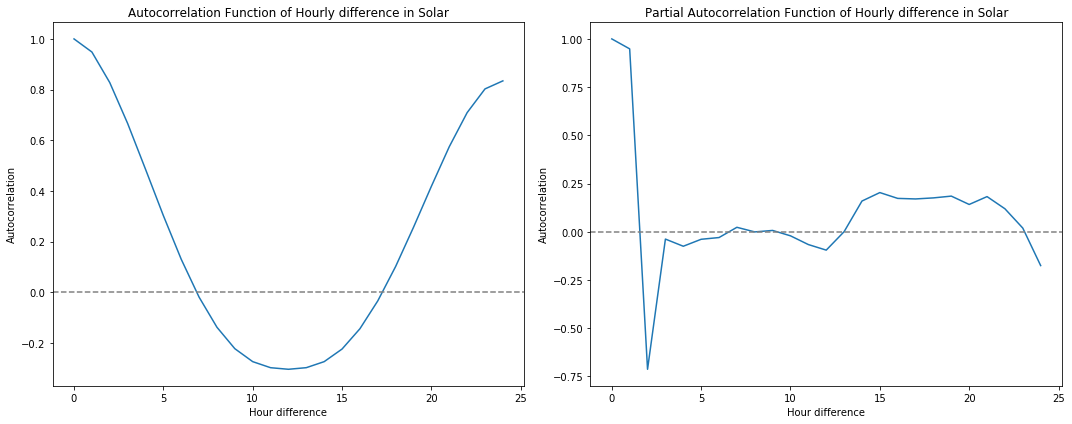

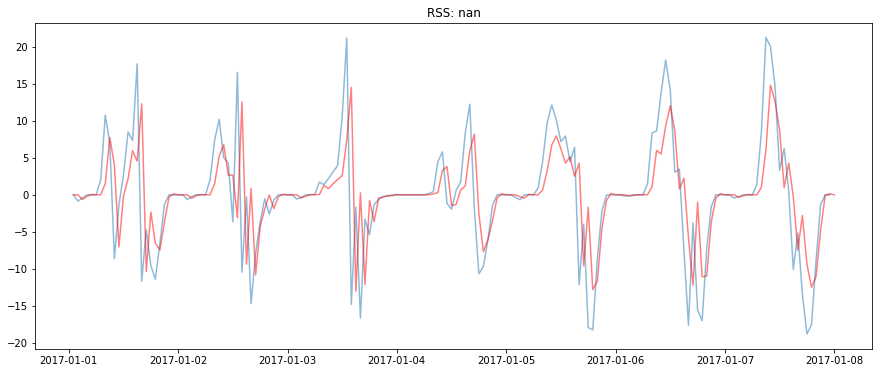

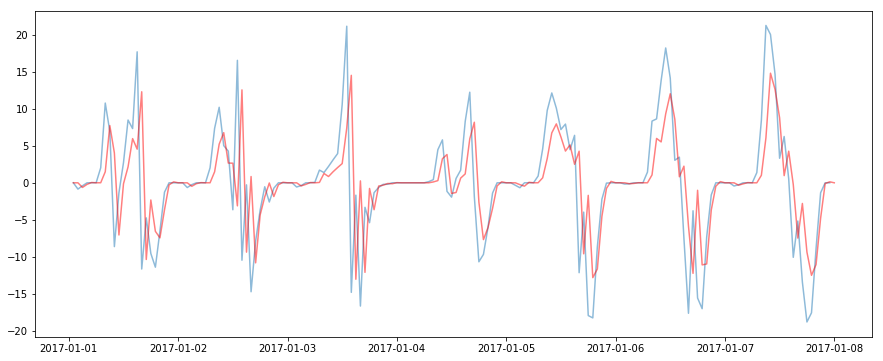

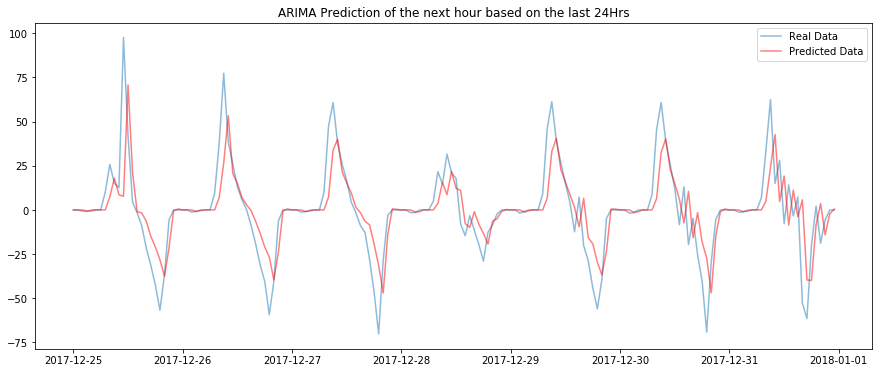

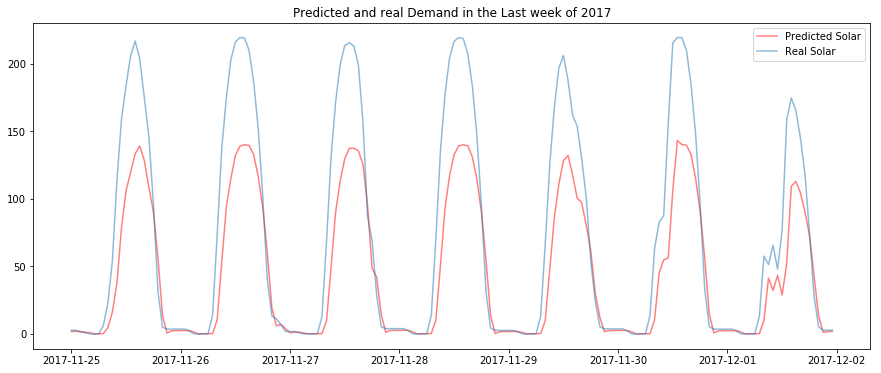

In [8]:
result = ARIMA_analysis('Solar', 24)
data17['Solar Prediction'] = result

/home/amrush/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


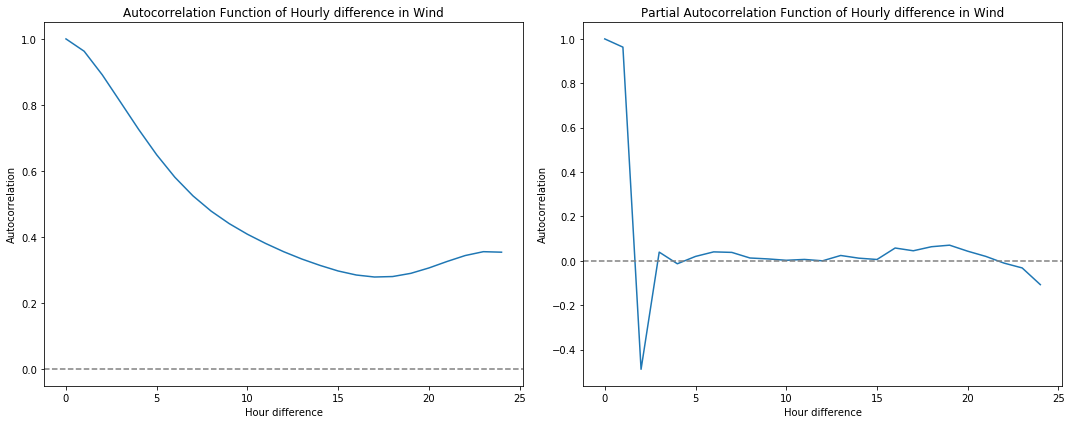

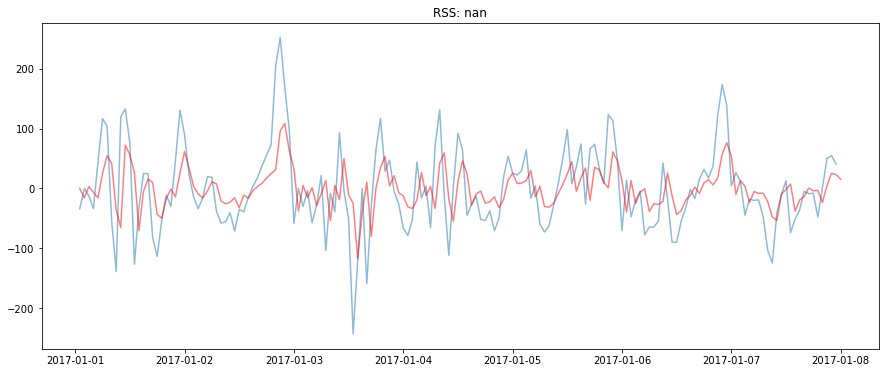

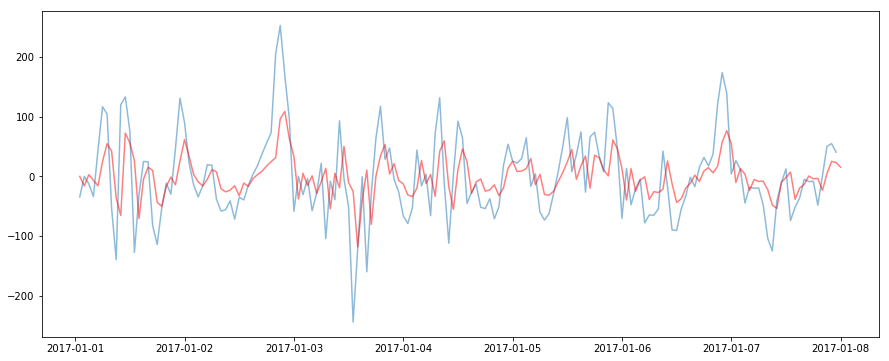

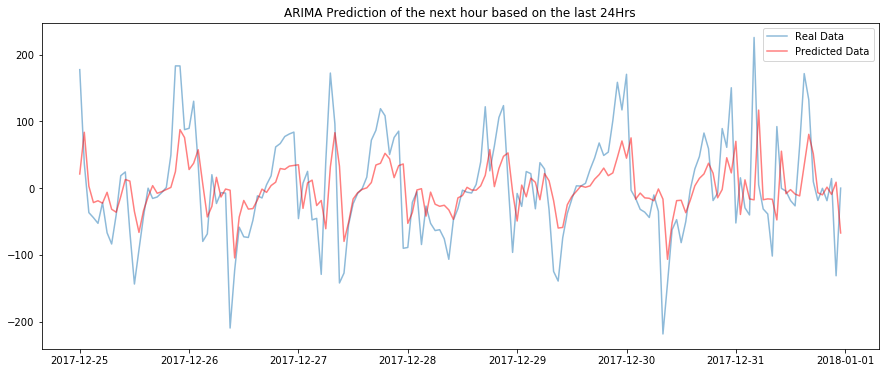

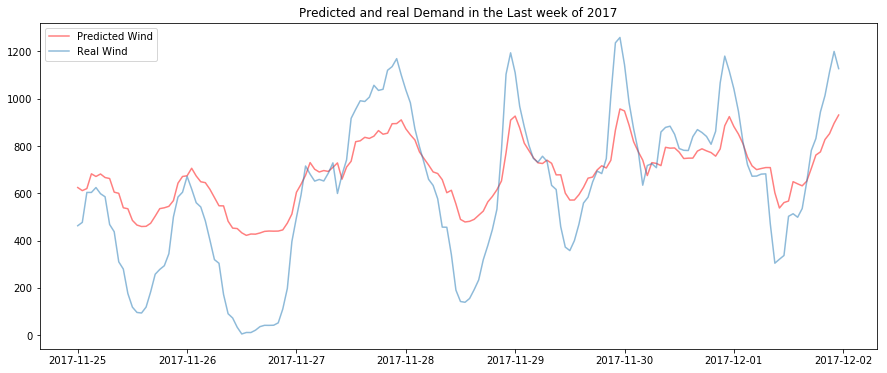

In [9]:
result = ARIMA_analysis('Wind', 24)
data17['Wind Prediction'] = result

/home/amrush/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


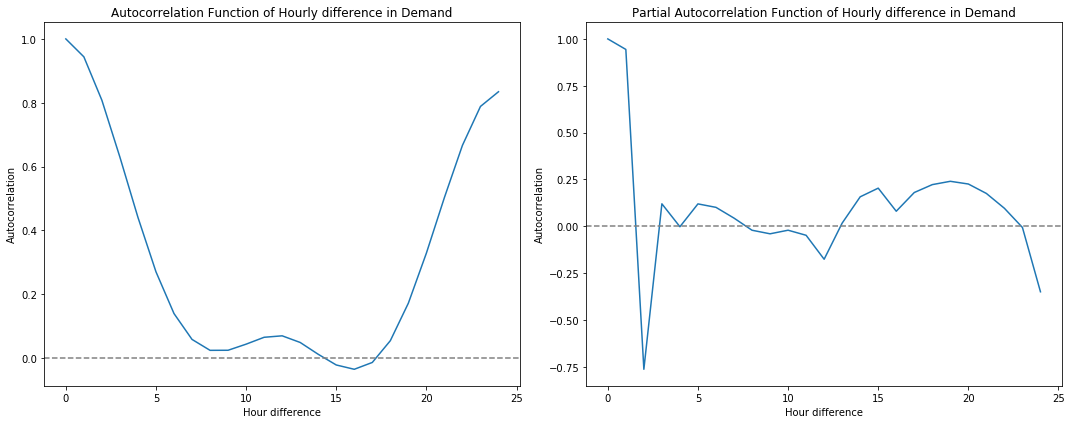

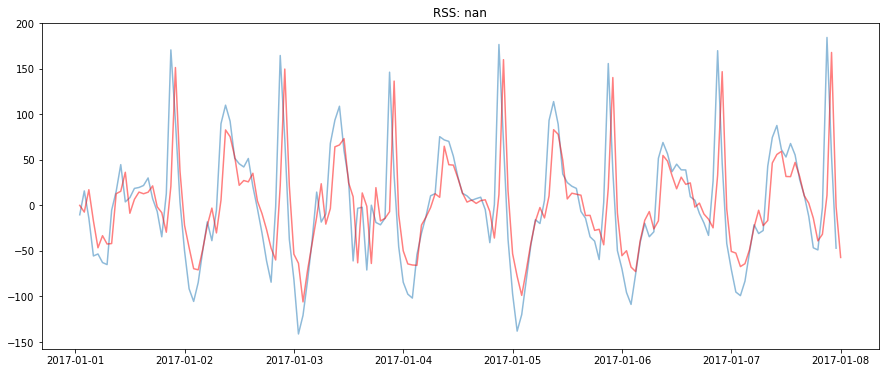

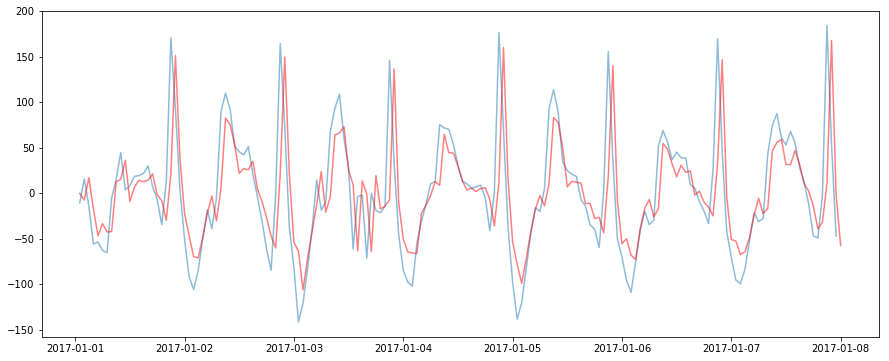

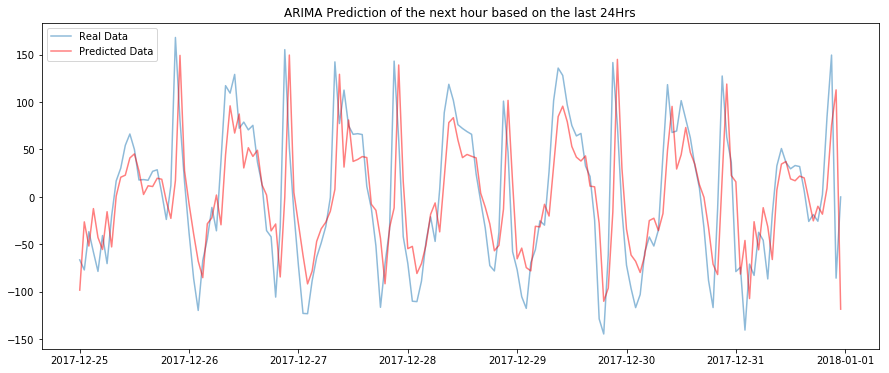

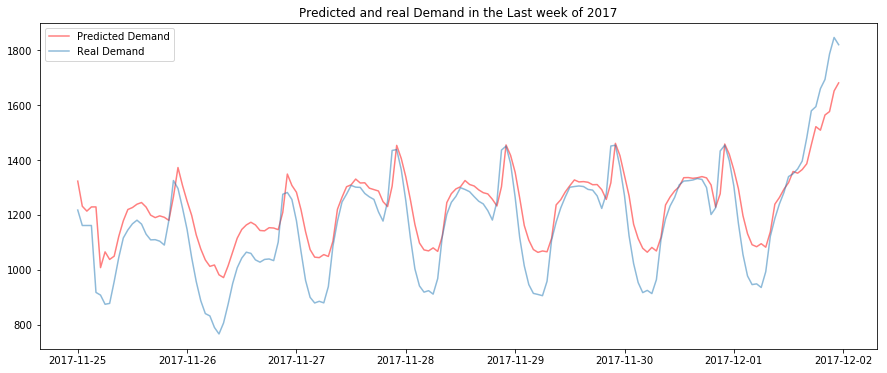

In [10]:
result = ARIMA_analysis('Demand', 24)
data17['Demand Prediction'] = result

In [11]:
#Date Picker, yeah it's manual and hardcoded, Add date picker functionality

beg = len(data17['Hydraulic'])-24*7-(30*24)
end = len(data17['Hydraulic'])-(30*24)

In [12]:
#Calculate the Hydraulic Power production for control purposes, and the percentage of maximum hydraulic production 
#capacity for pricing purposes

HydroNeed = []
HydroPerc = []

for ii in range(len(data17['Hydraulic'])):
    HydroNeed.append(data17['Demand Prediction'][ii]-data17['Wind Prediction'][ii]-data17['Solar Prediction'][ii])
    HydroPerc.append(100*(HydroNeed[ii]/1500))
    
data17['Hydraulic Need'] = HydroNeed
data17['Hydraulic Percentage'] = HydroPerc

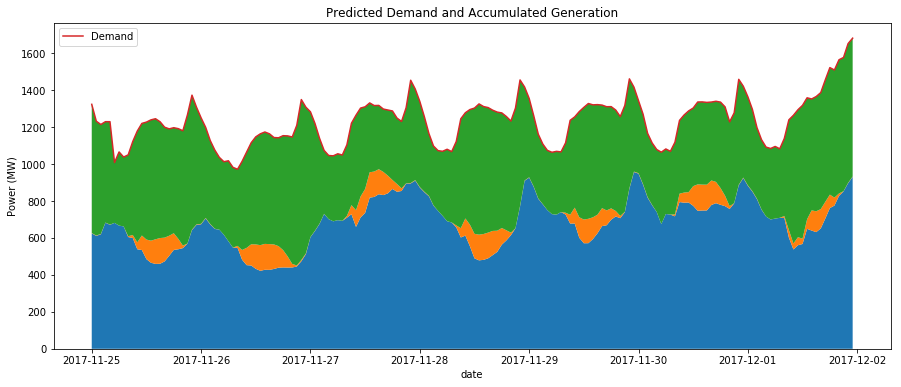

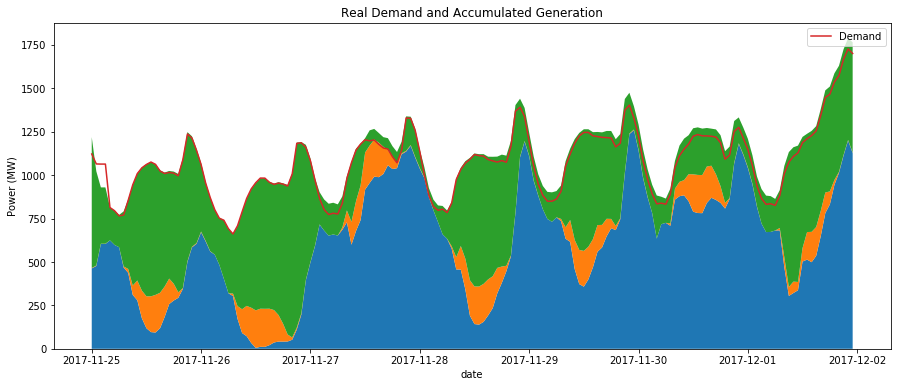

In [13]:
#Plotting the predicted demand, wind and solar predicted supply, Hydraulic need to augment demanded power supply
#Along with the real data, the predicted data fits perfectly because the Hydraulic energy is measured to fill the 
#gap between power demand and wind/solar supply. In reality, it will never be that smooth. 


plt.stackplot(data17.index[beg:end], data17['Wind Prediction'][beg:end], 
              data17['Solar Prediction'][beg:end], data17['Hydraulic Need'][beg:end])
plt.plot(data17['Demand Prediction'][beg:end], label='Demand')
plt.title('Predicted Demand and Accumulated Generation')
plt.ylabel('Power (MW)')
plt.xlabel('date')
plt.legend()

plt.figure()
plt.stackplot(data17.index[beg:end], data17['Wind'][beg:end], 
              data17['Solar'][beg:end], data17['Hydraulic'][beg:end])
plt.plot(data17['Demand'][beg:end]-data17['Biomass'][beg:end]-data17['Fossil Fuel'], label='Demand')
plt.title('Real Demand and Accumulated Generation')
plt.ylabel('Power (MW)')
plt.xlabel('date')
plt.legend()

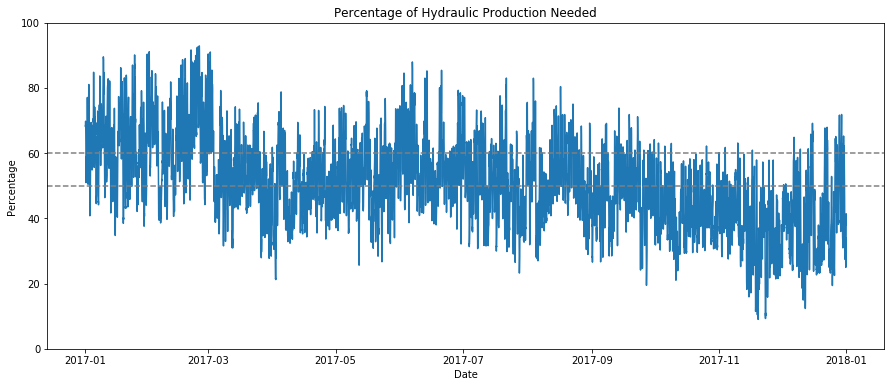

In [14]:
#plot the percentage of Hydraulic capacity used at the timeframe in question. The dashed gray lines are pricing range 
#used for set the 3-tier pricing


plt.plot(data17['Hydraulic Percentage'])
plt.ylim(0,100)
plt.title('Percentage of Hydraulic Production Needed')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.axhline(60,linestyle='--', color='gray')
plt.axhline(50,linestyle='--', color='gray')

(array([0.00066717, 0.00269592, 0.00894554, 0.02095462, 0.02826627,
        0.026646  , 0.01706052, 0.00920424, 0.00367625, 0.00115734]),
 array([ 9.03147613, 17.41554165, 25.79960717, 34.18367269, 42.56773821,
        50.95180373, 59.33586925, 67.71993477, 76.10400029, 84.48806581,
        92.87213133]),
 <a list of 10 Patch objects>)

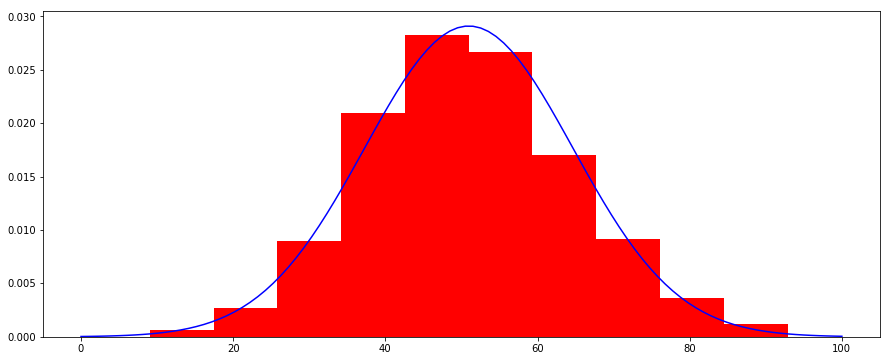

In [15]:
#Simple Analysis of the distribution of Hydraulic Production percentage

mean = np.mean(data17['Hydraulic Percentage'])
variance = np.var(data17['Hydraulic Percentage'])
sigma = np.sqrt(variance)
x = np.linspace(0, 100, 100)
plt.plot(x, mlab.normpdf(x, mean, sigma), color='blue')

histog = plt.hist(data17['Hydraulic Percentage'],normed=True, color='red')

histog

([<matplotlib.axis.YTick at 0x7f31dcab2c50>,
 <a list of 3 Text yticklabel objects>)

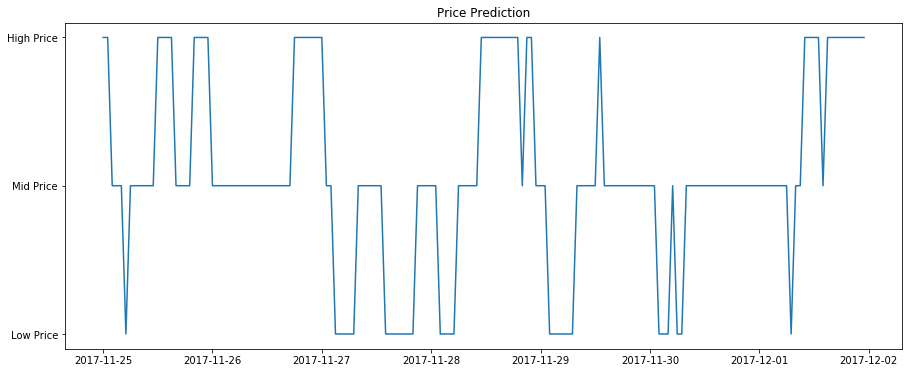

In [16]:
#Pricing Scheme for Hydraulic energy produced. 

price = list()
for ii in range(len(data17['Hydraulic Percentage'])):
    if data17['Hydraulic Percentage'][ii] > 41:
        price.append(int(2))
    if data17['Hydraulic Percentage'][ii] > 25 and data17['Hydraulic Percentage'][ii] <= 41:
        price.append(int(1))
    if data17['Hydraulic Percentage'][ii] <= 25:
        price.append(int(0))

        
data17['Price'] = price
plt.figure()
plt.plot(data17['Price'][beg:end])
plt.title('Price Prediction')
plt.yticks(np.arange(3),('Low Price','Mid Price','High Price'))

In [17]:
#Exporting final results to CSV file

data17.head()

cols = ['Hydraulic', 'Solar','Fossil Fuel','Biomass','Demand','Hydraulic Need','Hydraulic Percentage','Demand Prediction',
       'Wind Prediction','Solar Prediction','Price']

result = data17[cols]
result.to_csv('FinalResults.csv')

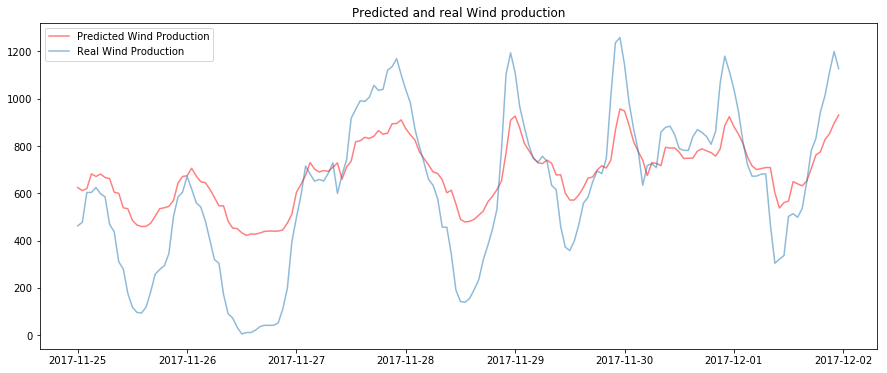

In [18]:
plt.figure()
plt.plot(data17['Wind Prediction'][beg:end],color='red', alpha=.5, label='Predicted Wind Production')
plt.plot(data17['Wind'][beg:end], alpha=.5, label='Real Wind Production')
plt.legend(loc='best')
plt.title('Predicted and real Wind production')
